In [8]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
import matplotlib.pyplot as plt
import kagglehub
from concurrent.futures import ThreadPoolExecutor
import random

In [9]:
np.random.seed(42)
tf.random.set_seed(42)

In [10]:
path = kagglehub.dataset_download("yasserhessein/gender-dataset")

100%|██████████| 1.32G/1.32G [00:18<00:00, 77.7MB/s]

Extracting files...


In [13]:
dataset_dir = path + "/Dataset"
image_size = (64, 64)
batch_size = 32
train_size = 16384
val_size = 4096
test_size = 4096

In [14]:
import cv2
face_cascade = cv2.CascadeClassifier(cv2.data.haarcascades + 'haarcascade_frontalface_default.xml')

def detect_faces(image):
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    faces = face_cascade.detectMultiScale(gray, scaleFactor=1.1, minNeighbors=5)

    if len(faces) == 0:
        return []

    return faces

In [15]:
def process_image(image_path, image_size, face_detection=True):
    image = cv2.imread(image_path)

    if face_detection:
        faces = detect_faces(image)
        if len(faces) == 0:
            return None

        for (x, y, w, h) in faces:
            cropped_face = image[y:y+h, x:x+w]
            cropped_face_resized = cv2.resize(cropped_face, image_size)
            return cropped_face_resized / 255.0

    else:
        image_resized = cv2.resize(image, image_size)
        return image_resized / 255.0

In [16]:
def preprocess_and_split_dataset(directory, image_size, train_size, val_size, test_size, face_detection=True, progress_interval=50):
    processed_images = []
    labels = []
    label_map = {'Male': 1, 'Female': 0}

    random.seed(42)
    all_image_paths = []
    all_labels = []

    for label, class_label in label_map.items():
        class_dir = f"{directory}/{label}"
        image_paths = list(tf.io.gfile.glob(f"{class_dir}/*"))
        random.shuffle(image_paths)
        all_image_paths.extend(image_paths)
        all_labels.extend([class_label] * len(image_paths))

    combined = list(zip(all_image_paths, all_labels))
    random.shuffle(combined)
    all_image_paths, all_labels = zip(*combined)

    for idx, (image_path, label) in enumerate(zip(all_image_paths, all_labels)):
        if len(processed_images) >= (train_size + val_size + test_size):
            break

        image = cv2.imread(image_path)
        if face_detection:
            faces = detect_faces(image)
            for (x, y, w, h) in faces:
                cropped_face = image[y:y+h, x:x+w]
                cropped_face_resized = cv2.resize(cropped_face, image_size)
                processed_images.append(cropped_face_resized / 255.0)
                labels.append(label)
                if len(processed_images) >= (train_size + val_size + test_size):
                    break
        else:
            resized_image = cv2.resize(image, image_size)
            processed_images.append(resized_image / 255.0)
            labels.append(label)

        if (len(processed_images)) % progress_interval == 0:
            print(f"Processed {len(processed_images)} images...")

    processed_images = np.array(processed_images)
    labels = np.array(labels)

    np.random.seed(42)
    indices = np.arange(len(processed_images))
    np.random.shuffle(indices)
    processed_images = processed_images[indices]
    labels = labels[indices]

    train_images = processed_images[:train_size]
    train_labels = labels[:train_size]
    val_images = processed_images[train_size:train_size + val_size]
    val_labels = labels[train_size:train_size + val_size]
    test_images = processed_images[train_size + val_size:train_size + val_size + test_size]
    test_labels = labels[train_size + val_size:train_size + val_size + test_size]

    print(f"Dataset split complete. Train: {len(train_images)}, Val: {len(val_images)}, Test: {len(test_images)}")

    return (train_images, train_labels), (val_images, val_labels), (test_images, test_labels)

In [19]:
(train_images, train_labels), (val_images, val_labels), (test_images, test_labels) = preprocess_and_split_dataset(
    f"{dataset_dir}/Train", image_size, train_size, val_size, test_size, face_detection=True)

Processed 50 images...
Processed 100 images...
Processed 150 images...
Processed 200 images...
Processed 200 images...
Processed 250 images...
Processed 300 images...
Processed 350 images...
Processed 400 images...
Processed 450 images...
Processed 500 images...
Processed 550 images...
Processed 600 images...
Processed 650 images...
Processed 700 images...
Processed 750 images...
Processed 800 images...
Processed 850 images...
Processed 900 images...
Processed 950 images...
Processed 1000 images...
Processed 1050 images...
Processed 1100 images...
Processed 1150 images...
Processed 1200 images...
Processed 1250 images...
Processed 1250 images...
Processed 1300 images...
Processed 1350 images...
Processed 1400 images...
Processed 1450 images...
Processed 1500 images...
Processed 1550 images...
Processed 1600 images...
Processed 1650 images...
Processed 1700 images...
Processed 1750 images...
Processed 1800 images...
Processed 1850 images...
Processed 1900 images...
Processed 1950 images

In [20]:
from tensorflow.keras import layers, models
model = models.Sequential([
    layers.Conv2D(32, (3, 3), activation='relu', input_shape=(64, 64, 3)),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Flatten(),
    layers.Dense(64, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(2, activation='softmax')
])
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

model.fit(train_images, train_labels, validation_data=(val_images, val_labels), epochs=10)

Epoch 1/10
512/512 ━━━━━━━━━━━━━━━━━━━━ 121s 232ms/step - accuracy: 0.7492 - loss: 0.4872 - val_accuracy: 0.8926 - val_loss: 0.2544
Epoch 2/10
512/512 ━━━━━━━━━━━━━━━━━━━━ 135s 219ms/step - accuracy: 0.9043 - loss: 0.2388 - val_accuracy: 0.8938 - val_loss: 0.2324
Epoch 3/10
512/512 ━━━━━━━━━━━━━━━━━━━━ 140s 216ms/step - accuracy: 0.9259 - loss: 0.1969 - val_accuracy: 0.9265 - val_loss: 0.1686
Epoch 4/10
512/512 ━━━━━━━━━━━━━━━━━━━━ 137s 207ms/step - accuracy: 0.9286 - loss: 0.1728 - val_accuracy: 0.9355 - val_loss: 0.1641
Epoch 5/10
512/512 ━━━━━━━━━━━━━━━━━━━━ 146s 215ms/step - accuracy: 0.9388 - loss: 0.1543 - val_accuracy: 0.9353 - val_loss: 0.1531
Epoch 6/10
512/512 ━━━━━━━━━━━━━━━━━━━━ 140s 212ms/step - accuracy: 0.9434 - loss: 0.1375 - val_accuracy: 0.9373 - val_loss: 0.1503
Epoch 7/10
512/512 ━━━━━━━━━━━━━━━━━━━━ 145s 218ms/step - accuracy: 0.9499 - loss: 0.1270 - val_accuracy: 0.9360 - val_loss: 0.1525
Epoch 8/10
512/512 ━━━━━━━━━━━━━━━━━━━━ 138s 211ms/step - accuracy: 0.9531 -

In [22]:
model.save("gender_classification_model.keras")

# Load the model
model = tf.keras.models.load_model("gender_classification_model.keras")

In [23]:
test_loss, test_acc = model.evaluate(test_images, test_labels)
print(f"Test accuracy: {test_acc*100}%")

128/128 ━━━━━━━━━━━━━━━━━━━━ 8s 61ms/step - accuracy: 0.9390 - loss: 0.1621
Test accuracy: 93.798828125%


In [24]:
def predict_gender_from_image(image, model):
    faces = detect_faces(image)

    if len(faces) == 0:
        return None

    for (x, y, w, h) in faces:
        cropped_face = image[y:y+h, x:x+w]
        cropped_face_resized = cv2.resize(cropped_face, (64, 64))
        cropped_face_resized = cropped_face_resized / 255.0

        cropped_face_resized = np.expand_dims(cropped_face_resized, axis=0)
        prediction = model.predict(cropped_face_resized)

        label = np.argmax(prediction, axis=1)
        gender = 'Male' if label == 1 else 'Female'
        confidence = float(prediction[0][label] * 100)

        cv2.rectangle(image, (x, y), (x + w, y + h), (0, 255, 0), 2)
        cv2.putText(image, f"{gender} - {confidence:.2f}%", (x, y - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.4, (0, 255, 0), 1)

    return image

In [25]:
from google.colab.patches import cv2_imshow

In [36]:
def process_input(input_type, image_path=None, model=None):
    if input_type == 'image':
        if image_path is None:
            print("Error: Image path is required for image input.")
            return

        image = cv2.imread(image_path)
        output_image = predict_gender_from_image(image, model)
        if output_image is not None:
            cv2_imshow(output_image)
            cv2.waitKey(0)
            cv2.destroyAllWindows()
        else:
            print("No faces detected.")

    elif input_type == 'webcam':
        cap = cv2.VideoCapture(0)
        while True:
            ret, frame = cap.read()
            if not ret:
                break
            output_image = predict_gender_from_image(frame, model)
            if output_image is not None:
                cv2_imshow(output_image)
            else:
                print("No faces detected.")

            if cv2.waitKey(1) & 0xFF == ord('q'):
                break

        cap.release()
        cv2.destroyAllWindows()

In [59]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [37]:
from IPython.display import display, Javascript
from google.colab.output import eval_js
from base64 import b64decode

def take_photo(filename='photo.jpg', quality=0.8):
  js = Javascript('''
    async function takePhoto(quality) {
      const div = document.createElement('div');
      const capture = document.createElement('button');
      capture.textContent = 'Capture';
      div.appendChild(capture);

      const video = document.createElement('video');
      video.style.display = 'block';
      const stream = await navigator.mediaDevices.getUserMedia({video: true});

      document.body.appendChild(div);
      div.appendChild(video);
      video.srcObject = stream;
      await video.play();

      // Resize the output to fit the video element.
      google.colab.output.setIframeHeight(document.documentElement.scrollHeight, true);

      // Wait for Capture to be clicked.
      await new Promise((resolve) => capture.onclick = resolve);

      const canvas = document.createElement('canvas');
      canvas.width = video.videoWidth;
      canvas.height = video.videoHeight;
      canvas.getContext('2d').drawImage(video, 0, 0);
      stream.getVideoTracks()[0].stop();
      div.remove();
      return canvas.toDataURL('image/jpeg', quality);
    }
    ''')
  display(js)
  data = eval_js('takePhoto({})'.format(quality))
  binary = b64decode(data.split(',')[1])
  with open(filename, 'wb') as f:
    f.write(binary)
  return filename

<IPython.core.display.Javascript object>

Saved to photo.jpg


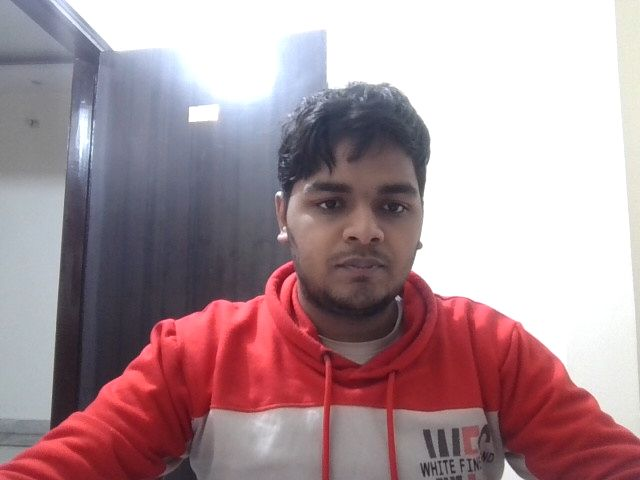

In [45]:
from IPython.display import Image
try:
  filename = take_photo()
  print('Saved to {}'.format(filename))

  # Show the image which was just taken.
  display(Image(filename))
except Exception as err:
  # Errors will be thrown if the user does not have a webcam or if they do not
  # grant the page permission to access it.
  print(str(err))

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step


<ipython-input-24-501f477cb501>:17: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  confidence = float(prediction[0][label] * 100)


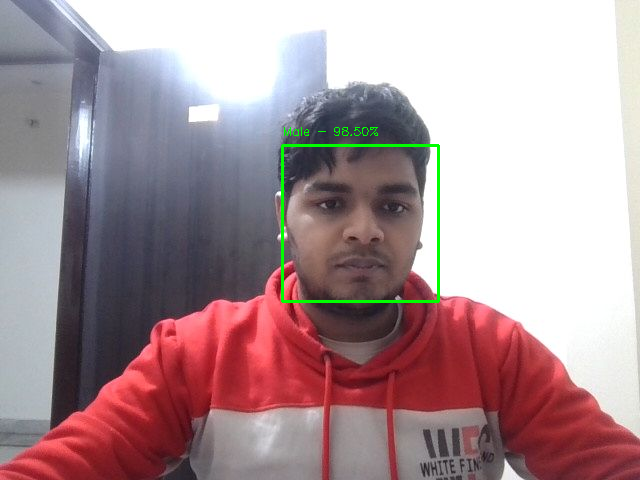

In [62]:
image_path = 'photo.jpg'
process_input('image', image_path, model)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


<ipython-input-24-501f477cb501>:17: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  confidence = float(prediction[0][label] * 100)


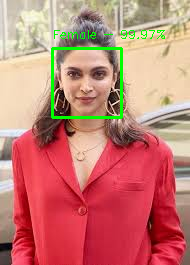

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


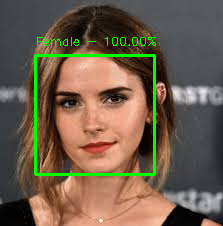

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


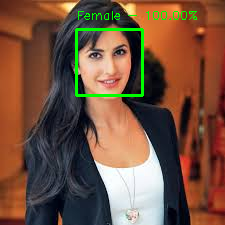

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


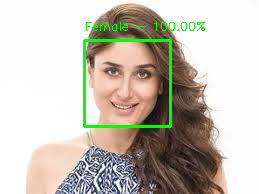

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


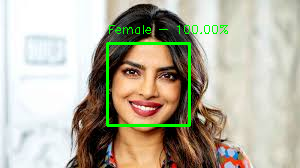

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


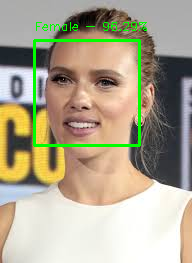

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


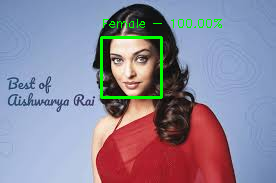

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


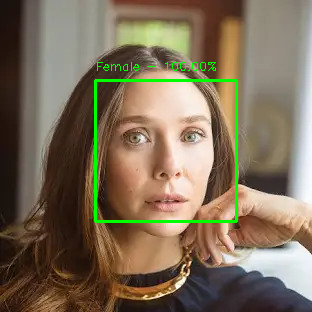

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


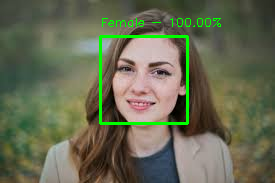

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


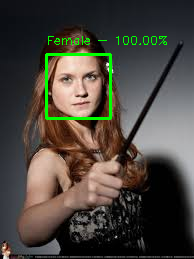

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


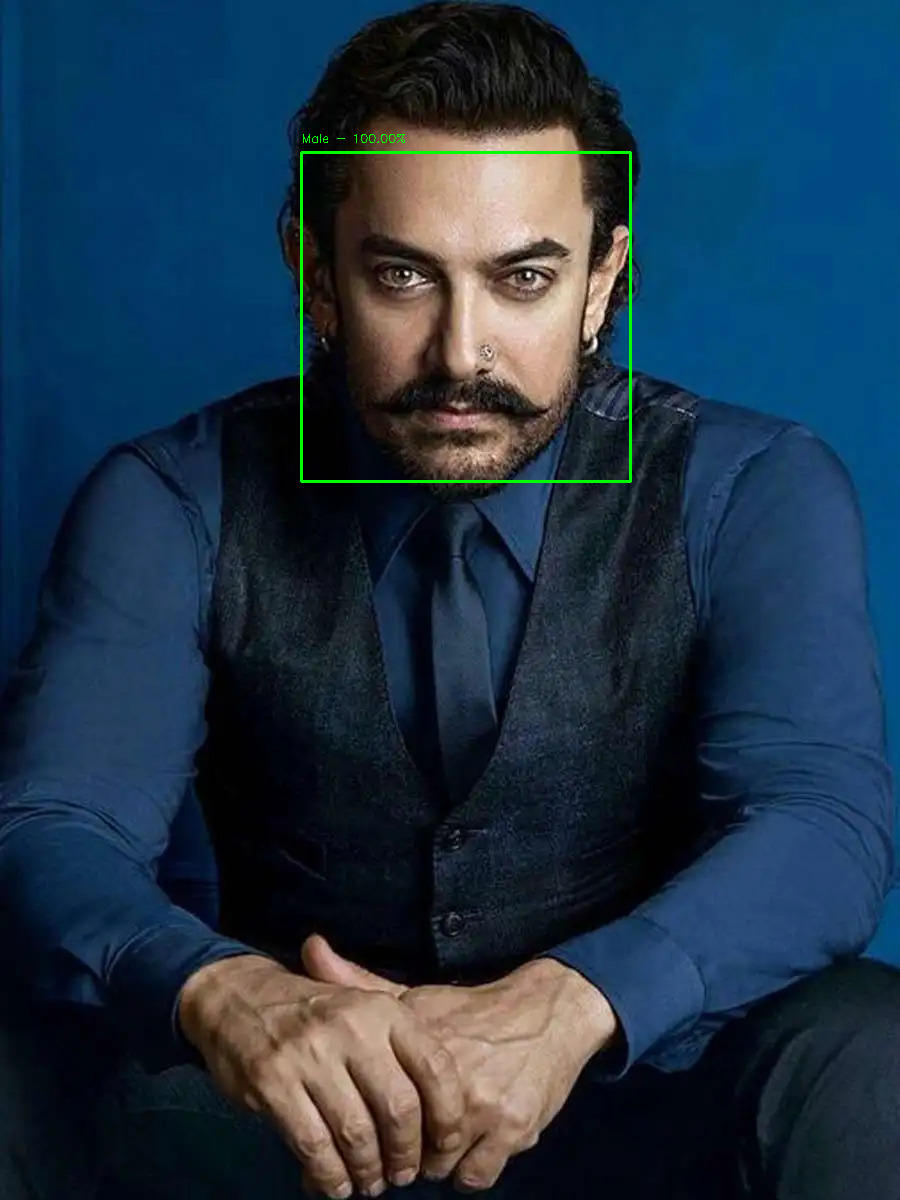

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


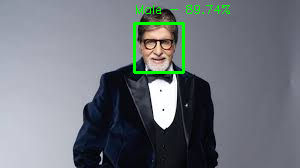

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


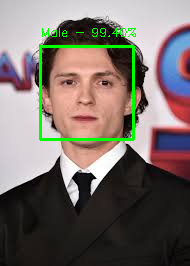

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


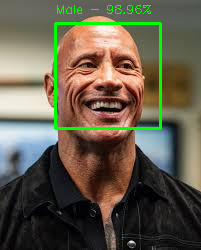

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step


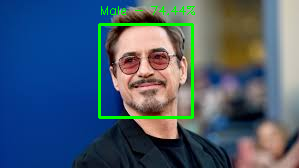

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


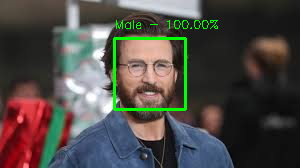

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


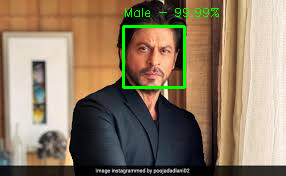

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


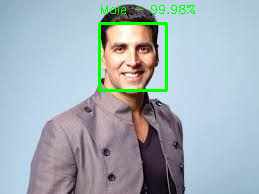

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


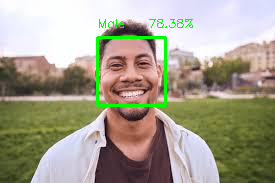

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


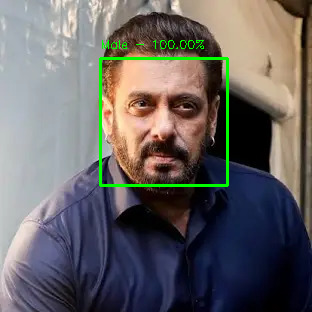

In [66]:
for i in range(1,21):
  image_path=f'/content/drive/My Drive/input_sample_dataset/single/single ({i}).jpeg'
  process_input('image',image_path,model)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


<ipython-input-24-501f477cb501>:17: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  confidence = float(prediction[0][label] * 100)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


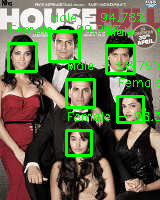

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


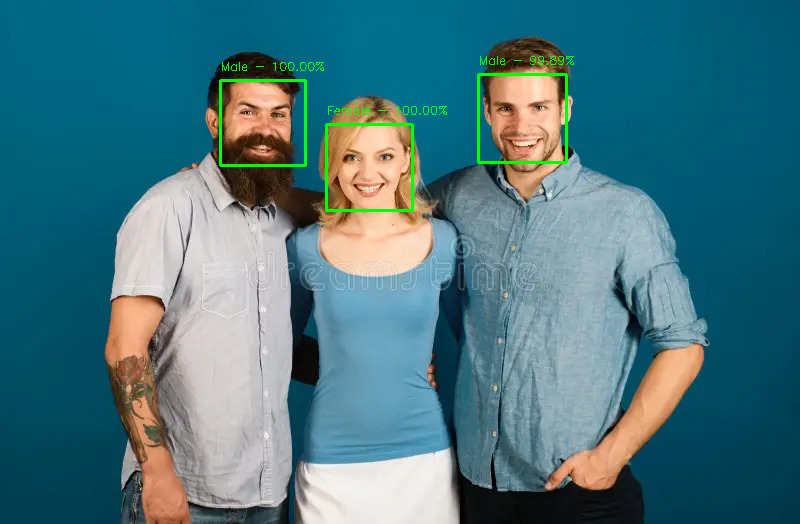

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


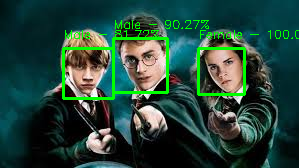

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


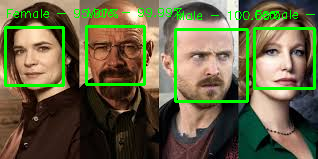

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


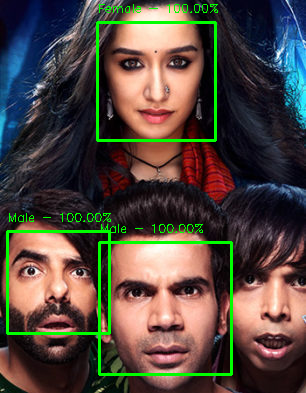

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


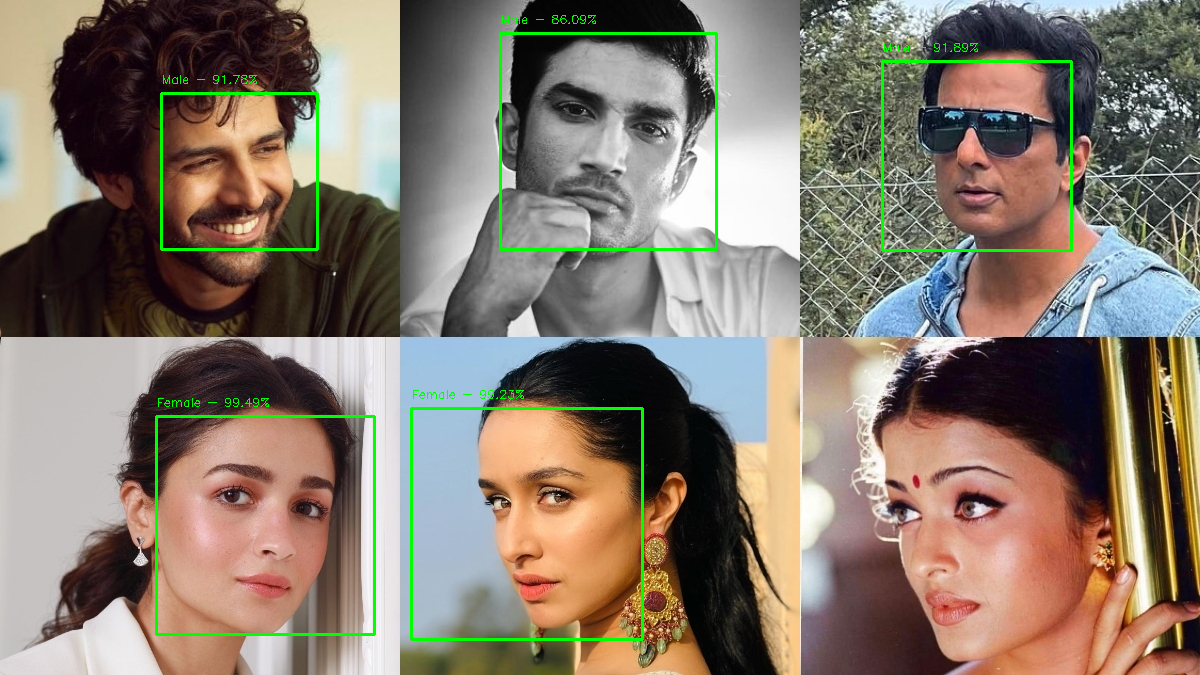

In [96]:
for i in range(1,7):
  image_path=f'/content/drive/My Drive/input_sample_dataset/group/groups ({i}).jpeg'
  process_input('image',image_path,model)